In [267]:
import requests
contracts_url = 'https://www.politicalalertengine.com/api/contracts/all'

r = requests.get(contracts_url)

contracts = r.json()

prices_url = 'https://www.politicalalertengine.com/api/analytics/dataByIds/%d'

prices = requests.get(prices_url % 4390).json()

In [167]:
import pandas as pd
df = pd.DataFrame(prices)

import numpy as np
df['date'] = pd.to_datetime(df['date'])
df['lastTradePrice'] = df['lastTradePrice'].astype(np.float64)

c_df = pd.DataFrame(contracts)

c_df[c_df['predictItId'] == 4390]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(df['date'],df['lastTradePrice'])

In [170]:
df['dateCol'] = df['date']
df= df.set_index('date')


df = df[df.index <= '2020-10-20']

In [ ]:
daily_px = df.resample('1D',how='mean')
daily_px = daily_px.ffill()
daily_px = daily_px.bfill()

daily_px.index += datetime.timedelta(days=1)

plt.plot(daily_px['lastTradePrice'])

plt.show()

daily_px['ret'] = daily_px['lastTradePrice'].diff()

_ = plt.hist(daily_px['ret'],bins=50)
plt.show()

plt.scatter(daily_px['ret'],daily_px['ret'].shift(-1))
plt.show()

daily_px['ret'].corr(daily_px['ret'].shift(-1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


(-10, 10)

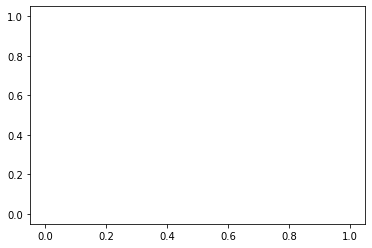

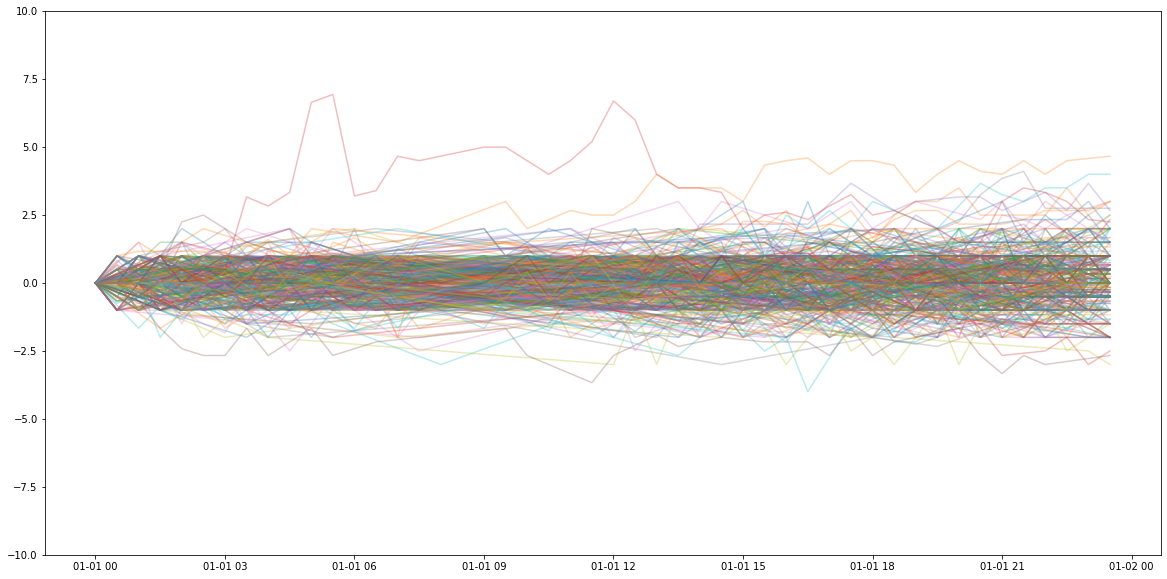

In [237]:
#######################
# time of day effects #
#######################

# average/median intraday price movement
plt.locator_params(nbins=10)

g_day = df.groupby(df.index.date)
# g_week = df.groupby(pd.Grouper(key='dateCol',freq='W-MON'))
fig = plt.figure(figsize=(20,10))
price_days = [] 
for n,g in g_day:
    if len(g) < 5:
        continue
#     print(g.columns)
#     g = g.set_index('date')
    g = g.sort_index()
#     print(g)
    g = g.resample('30T', how='mean').interpolate(method='time')
#     print(g)
    midnight = g.index[0].replace(hour=0,minute=0, second=0,microsecond=0)
#     print(pd.date_range(midnight, midnight + datetime.timedelta(hours=23,minutes=59),freq='30T'))
    g = g.reindex(pd.date_range(midnight, midnight + datetime.timedelta(hours=23,minutes=59),freq='30T'))
#     print(g)
#     print(g)
    g = g.bfill()
    g = g.ffill()
    start_price = g['lastTradePrice'].iloc[0]
    
#     xaxis = g.index.time
    xaxis = g.index - g.index[0]
#     print(xaxis)
    
    plt.plot([pd.to_datetime('2020-01-01').normalize() + dt for dt in xaxis],g['lastTradePrice'] - start_price,alpha=0.3)
#     print(len(g['lastTradePrice'].values))
    price_days.append(list(g['lastTradePrice'].values))
plt.ylim((-10,10))

In [238]:
price_days = np.array(price_days)

In [239]:
print('expect %d days of data' % (df.index[-1] - df.index[0]).days)

expect 499 days of data


In [240]:
print('actually %d days of data' % len(price_days))

actually 431 days of data


In [241]:
price_diffs

array([[ 0.00000000e+00, -1.03906266e-03, -2.07812532e-03, ...,
         1.15399213e+00,  1.15295307e+00,  1.15191401e+00],
       [ 0.00000000e+00, -1.03906266e-03, -1.00207813e+00, ...,
        -1.34600787e+00, -1.34704693e+00, -1.34808599e+00],
       [ 0.00000000e+00, -1.03906266e-03, -2.07812532e-03, ...,
        -1.84600787e+00, -1.84704693e+00, -1.84808599e+00],
       ...,
       [ 0.00000000e+00, -1.03906266e-03,  9.97921875e-01, ...,
         5.82065880e+00,  5.65295307e+00,  5.65191401e+00],
       [ 0.00000000e+00,  2.48960937e-01,  2.47921875e-01, ...,
         1.90399213e+00,  9.02953072e-01,  1.90191401e+00],
       [ 0.00000000e+00,  8.32294271e-01,  1.64588541e-01, ...,
        -1.34600787e+00, -2.47046928e-01, -3.93540536e-01]])

In [ ]:
price_diffs = pri

In [242]:
avg_ret = (price_days[:,-1] - price_days[:,0]).mean()


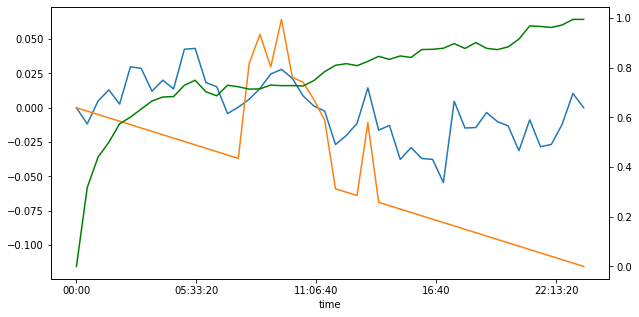

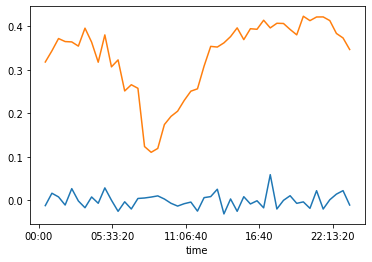

In [245]:
# price_chngs = np.diff(price_days,axis=1)
dt = datetime.datetime(2020,1,1).replace(hour=0,minute=0, second=0,microsecond=0)
xaxis = pd.date_range(dt, dt + datetime.timedelta(hours=23,minutes=59),freq='30T').time

price_chngs = (price_days[:,1:] - price_days[:,:-1])
price_chngs -= avg_ret / price_chngs.shape[1]

price_diffs = np.concatenate(([[0]]*len(price_chngs),price_chngs.cumsum(axis=1)),axis=1)
#
# price_diffs = (price_days[:,:].T - price_days[:,0]).T
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
ax1.plot(xaxis,price_diffs.mean(axis=0),label='mean')
ax1.plot(xaxis,np.median(price_diffs,axis=0),label='median')
ax2.plot(xaxis,np.std(price_diffs,axis=0),color='green',label='std')


plt.show()




plt.plot(xaxis[1:], price_chngs.mean(axis=0))
plt.plot(xaxis[1:], price_chngs.std(axis=0))


In [ ]:
# why is standard deviation lower on weekends?

# intraday vol probably lowest from 5:30-10 CST/NYC or so becaus all timezones aree quite late

In [229]:
price_days.shape

(71, 336)

In [214]:
avg_ret = (price_days[:,-1] - price_days[:,0]).mean()


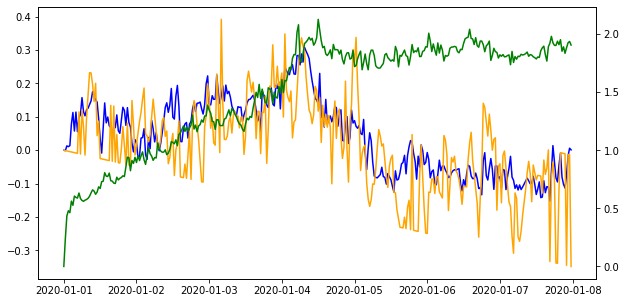

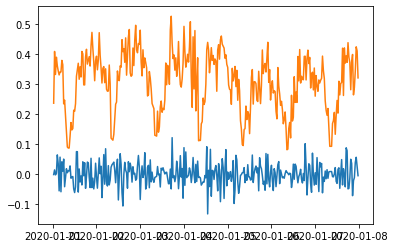

In [231]:
# price_chngs = np.diff(price_days,axis=1)

dt = datetime.datetime(2020,1,1).replace(hour=0,minute=0, second=0,microsecond=0)
xaxis = pd.date_range(dt, dt + datetime.timedelta(days=6,hours=23,minutes=59),freq='30T')

price_chngs = (price_days[:,1:] - price_days[:,:-1])
price_chngs -= avg_ret / price_diffs.shape[1]

price_diffs = np.concatenate(([[0]]*len(price_chngs),price_chngs.cumsum(axis=1)),axis=1)
# (price_days[:,:].T - price_days[:,0]).T

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
ax1.plot(xaxis,price_diffs.mean(axis=0),color='blue',label='mean')
ax1.plot(xaxis,np.median(price_diffs,axis=0),color='orange',label='median')
ax2.plot(xaxis,np.std(price_diffs,axis=0),color='green',label='std')

plt.show()




plt.plot(xaxis[1:], price_chngs.mean(axis=0))
plt.plot(xaxis[1:], price_chngs.std(axis=0))


In [230]:
from scipy.stats import ttest_ind

In [234]:
friday_start = 144
friday_end = friday_start + 96

friday_chngs = price_chngs[:,friday_start:friday_end].cumsum(axis=1)[:,-1]
print(friday_chngs.mean(), friday_chngs.std())

-0.2190770397488688 0.9512099871449224


In [251]:
daily_px = df.resample('1D',how='mean')
daily_px = daily_px.ffill()
daily_px = daily_px.bfill()

daily_px.index += datetime.timedelta(days=1)

plt.plot(daily_px['lastTradePrice'])

plt.show()

daily_px['ret'] = daily_px['lastTradePrice'].diff()

_ = plt.hist(daily_px['ret'],bins=50)
plt.show()

plt.scatter(daily_px['ret'],daily_px['ret'].shift(-1))
plt.show()

daily_px['ret'].corr(daily_px['ret'].shift(-1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


In [ ]:
import statsmodels.api as sm

In [220]:
price_diffs.cumsum(axis=1)[:,-1].mean()

72.42427488395793

In [57]:
import datetime
day = g_day.get_group(datetime.date(2020,1,1))

In [47]:
daily_index = pd.date_range("00:01", "23:59", freq="30min").time

# day['lastTradePrice'].reindex(pd.interpolate(method='time')

In [32]:
df['date'].diff().nlargest(25)

566    1 days 23:29:17.602000
1295   1 days 16:00:23.178000
1      1 days 09:59:14.253000
162    1 days 05:04:23.353000
687    1 days 04:46:52.084000
164    1 days 04:01:42.704000
4071   1 days 03:57:00.997000
3      1 days 03:55:04.401000
887    1 days 03:19:23.041000
432    1 days 03:03:09.184000
1436   1 days 01:56:31.773000
1570   1 days 01:09:21.673000
1397   1 days 01:05:47.213000
498    1 days 00:25:44.458000
652    0 days 23:49:40.963000
4050   0 days 22:45:12.498000
474    0 days 22:44:31.883000
348    0 days 22:41:49.531000
484    0 days 22:37:45.137000
253    0 days 22:24:53.918000
586    0 days 22:06:26.613000
1259   0 days 21:25:39.103000
4190   0 days 20:43:23.966000
662    0 days 20:37:06.114000
1269   0 days 20:33:01.807000
Name: date, dtype: timedelta64[ns]